In [8]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [9]:
from torchvision import models
from torchvision import transforms
import os

In [10]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised" or os.path.split(os.getcwd())[1] == "misc"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [11]:
cuda=True

In [12]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

train = ImageDataset(dataset=datasets.TRAINING_LABELED_80, network_input_size=256, cuda = True)
val = ImageDataset(dataset=datasets.VALIDATION_LABELED_20, network_input_size=256, cuda = True)

train = DataLoader(train, batch_size=64, shuffle=True)
val = DataLoader(val, batch_size=64, shuffle=True)

In [13]:
# Create a small convolutional neural network with input size 256x256 and 251 output classes, 3 convolutional layers and 2 fully connected layers with ReLU activation functions

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2), # 256x256x3 -> 256x256x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 256x256x32 -> 128x128x32   
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # 128x128x32 -> 128x128x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 128x128x64 -> 64x64x64
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), # 64x64x64 -> 64x64x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 64x64x128 -> 32x32x128
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(32*32*128, 500)
        self.fc2 = nn.Linear(500, 251)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = self.fc2(out)
        return out

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = ConvNet()
model.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
best_model_path = 'misc/models/best_baseline.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in train:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(train)}')
        labels = [int(label) for label in labels]
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(train)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(train))
    print('Validation:')
    model.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in val:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(val)}')            
            labels=[int(lable) for lable in labels]
            
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = model(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(val)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(val))
    val_acc.append(100*correct/total)
        
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with degraded validation loss: {best_val_loss} and accuracy: {100*correct/total}')

Epoch: 1
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.528775101616269, Accuracy: 0.24900398406374502%
Validation:
Batch 10 di 16
Validation Loss: 5.524812668561935, Accuracy: 0.398406374501992%
Best model saved with degraded validation loss: 5.524812668561935 and accuracy: 0.398406374501992
Epoch: 2
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.50771703417339, Accuracy: 0.647410358565737%
Validation:
Batch 10 di 16
Validation Loss: 5.502131104469299, Accuracy: 0.896414342629482%
Best model saved with degraded validation loss: 5.502131104469299 and accuracy: 0.896414342629482
Epoch: 3
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.36040042695545, Accuracy: 1.9920318725099602%
Validation:
Batch 10 di 16
Validation Loss: 5.428385764360428, Accuracy: 1.593625498007968%
Best model 

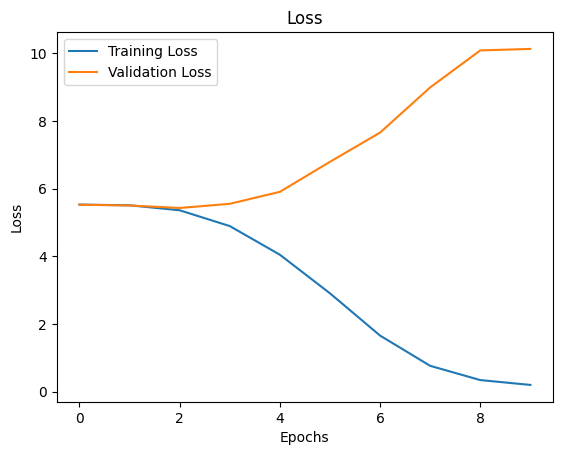

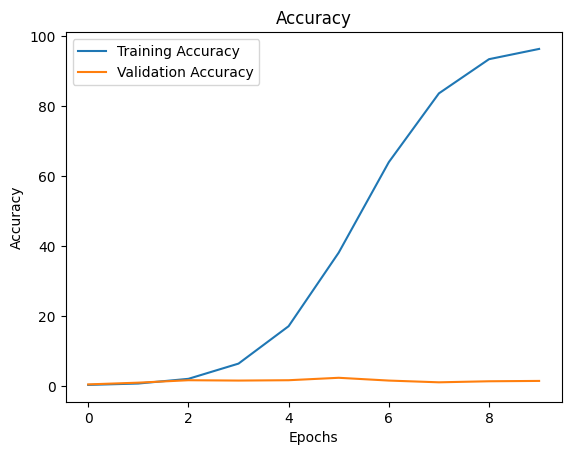

In [16]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)